## 모듈 임포트

In [1]:
import pandas as pd
from datetime import datetime, timedelta

## 데이터 로드

In [27]:
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')

## 데이터 병합 
- 가장 나중의 예측 데이터가 가장 좋다고 가정.

In [28]:
def to_date(x):
    return timedelta(hours=x)

In [29]:
def generate_df(df_):
    df = df_.copy()

    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])

    # 20 시
    a = df[df["forecast"] == 4.0]
    a = a[a["Forecast time"].apply(lambda x: "20:00:00" in x)]
    a.loc[:, 'Forecast_time'] = a.loc[:, 'Forecast_time'] + a.loc[:, 'forecast'].map(to_date)

    # 23 시
    b = df[df["forecast"] <= 22]
    b = b[b["Forecast time"].apply(lambda x: "23:00:00" in x)]
    b.loc[:, 'Forecast_time'] = b.loc[:, 'Forecast_time'] + b.loc[:, 'forecast'].map(to_date)

    # 병합
    c = pd.concat([a, b])
    print(f"20시 사용 데이터 길이 : {len(a)}")
    print(f"23시 사용 데이터 길이 : {len(b)}")
    print(f"합친 데이터 길이 : {len(c)}")
    print()

    # 정렬
    c.sort_values(by=['Forecast_time'], inplace=True)
    c = c[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    return c

In [30]:
dangjin_filled = generate_df(dangjin_fcst)
ulsan_filled = generate_df(ulsan_fcst)

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768



## 보간

In [31]:
def interpolate_df(df, method='linear'):
    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    return new_df.interpolate(method=method)

In [32]:
dangjin_interpolated = interpolate_df(dangjin_filled, method='linear')
ulsan_interpolated = interpolate_df(ulsan_filled, method='linear')

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

## 학습 데이터 전처리

In [34]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LGBM custom metric

In [35]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [36]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [64]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [65]:
dangjin_interpolated

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,50.000000,5.800000,336.000000,1.0
1,2018-03-02 01:00:00,-2.333333,51.666667,5.533333,337.000000,1.0
2,2018-03-02 02:00:00,-2.666667,53.333333,5.266667,338.000000,1.0
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0
...,...,...,...,...,...,...
26297,2021-03-01 17:00:00,7.333333,86.666667,5.966667,131.333333,4.0
26298,2021-03-01 18:00:00,6.000000,85.000000,7.600000,17.000000,4.0
26299,2021-03-01 19:00:00,5.333333,83.333333,7.466667,20.333333,4.0
26300,2021-03-01 20:00:00,4.666667,81.666667,7.333333,23.666667,4.0


In [66]:
dangjin_interpolated['Forecast_time'] = dangjin_interpolated['Forecast_time'].astype('str')
ulsan_interpolated['Forecast_time'] = ulsan_interpolated['Forecast_time'].astype('str')

## 당진 수상태양광 예측 모델 학습

In [67]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	valid_0's l1: 65.2939	valid_0's score: 8.52359


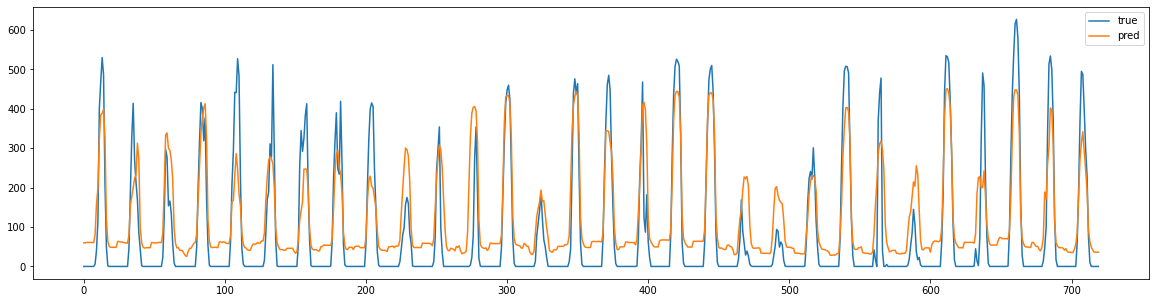

CV Score :  8.523591303464043


In [68]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 당진 자재 창고 태양광 예측 모델 학습

In [69]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 11949, number of used features: 9
[LightGBM] [Info] Start training from score 193.765671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's l1: 52.4063	valid_0's score: 10.0836


## 당진 태양광 예측 모델 학습

In [70]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_interpolated, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 11349, number of used features: 9
[LightGBM] [Info] Start training from score 308.414486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	valid_0's l1: 87.2042	valid_0's score: 10.6087


## 울산 태양광 예측 모델 학습

In [71]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_interpolated, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 17.9528	valid_0's score: 6.21949
Early stopping, best iteration is:
[682]	valid_0's l1: 14.343	valid_0's score: 6.18864


## 테스트 데이터 전처리

In [72]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [73]:
dangjin_test = test_datast(dangjin_interpolated)
ulsan_test = test_datast(ulsan_interpolated)

## 각 발전소 발전량 추론

In [74]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

## 제출

In [61]:
submission = pd.read_csv('./data/sample_submission.csv')

In [75]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [76]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,40.190800,37.378693,59.515770,3.077009
1,2021-02-01 02:00:00,32.341027,30.732927,56.428088,-0.963425
2,2021-02-01 03:00:00,32.835021,28.548579,58.022827,-0.041407
3,2021-02-01 04:00:00,31.170214,29.062793,55.038916,-4.203881
4,2021-02-01 05:00:00,31.170214,29.062793,55.038916,-4.758476
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [78]:
submission.to_csv('dacon_baseline.csv', index=False)